The end result of this exercise should be a file named prepare.py.

Using your store items data:

1. Convert date column to datetime format.
2. Plot the distribution of sale_amount and item_price.
3. Set the index to be the datetime variable.
4. Add a 'month' and 'day of week' column to your dataframe.
5. Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.
6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results

# Preparing Time Series Data
Like most preparation processes, but now with dates!

In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from env import user, password, host
import os
# from acquire import wrangle_store_data

import warnings
warnings.filterwarnings("ignore")

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire
We'll start by loading up the data from mysql server.

In [2]:
# The following are functions contained in the accompanying acquire.py file

def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    query = '''
    SELECT *
    FROM items
    JOIN sales USING(item_id)
    JOIN stores USING(store_id) 
    '''
    
    df = pd.read_sql(query, get_db_url('tsa_item_demand'))
    
    df.to_csv('tsa_item_demand.csv', index=False)
    
    return df

def wrangle_store_data():
    filename = 'tsa_store_data.csv'
    
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
        
    return df

In [3]:
df = wrangle_store_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28932 entries, 0 to 28931
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   store_id       28932 non-null  int64  
 1   item_id        28932 non-null  int64  
 2   item_upc14     28932 non-null  int64  
 3   item_upc12     28932 non-null  int64  
 4   item_brand     28932 non-null  object 
 5   item_name      28932 non-null  object 
 6   item_price     28931 non-null  float64
 7   sale_id        28931 non-null  float64
 8   sale_date      28931 non-null  object 
 9   sale_amount    28931 non-null  float64
 10  store_address  28931 non-null  object 
 11  store_zipcode  28931 non-null  float64
 12  store_city     28931 non-null  object 
 13  store_state    28931 non-null  object 
dtypes: float64(4), int64(4), object(6)
memory usage: 3.1+ MB


In [5]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1.0,2013-01-01,13.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2.0,2013-01-02,11.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3.0,2013-01-03,14.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4.0,2013-01-04,13.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5.0,2013-01-05,10.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX


1. Convert date column to datetime format.

In [6]:
df['sale_date'] = pd.to_datetime(df.sale_date)

2. Plot the distribution of sale_amount and item_price.

<AxesSubplot:>

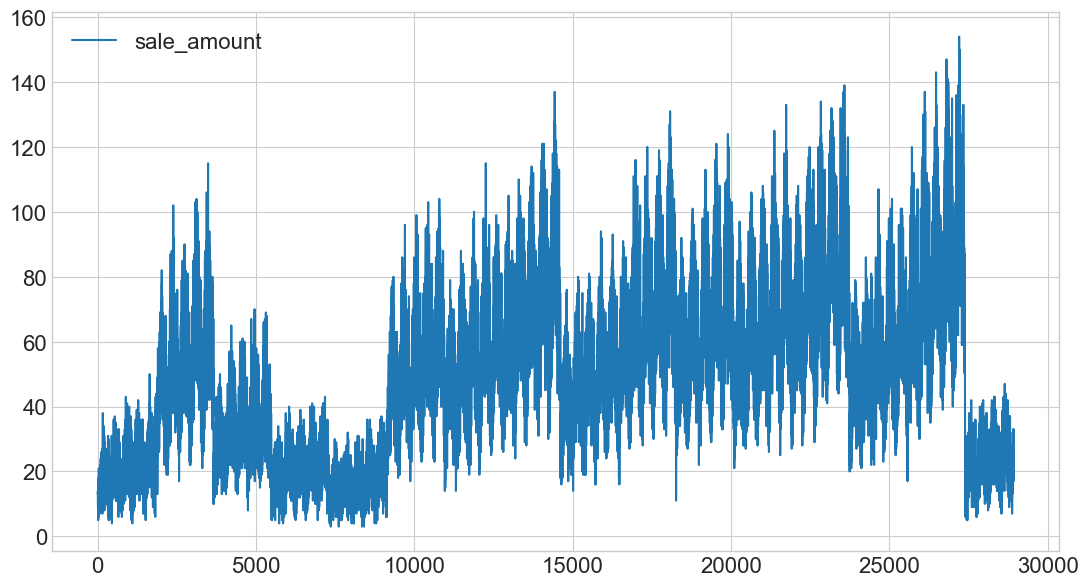

In [7]:
df[['sale_amount']].plot()

<AxesSubplot:>

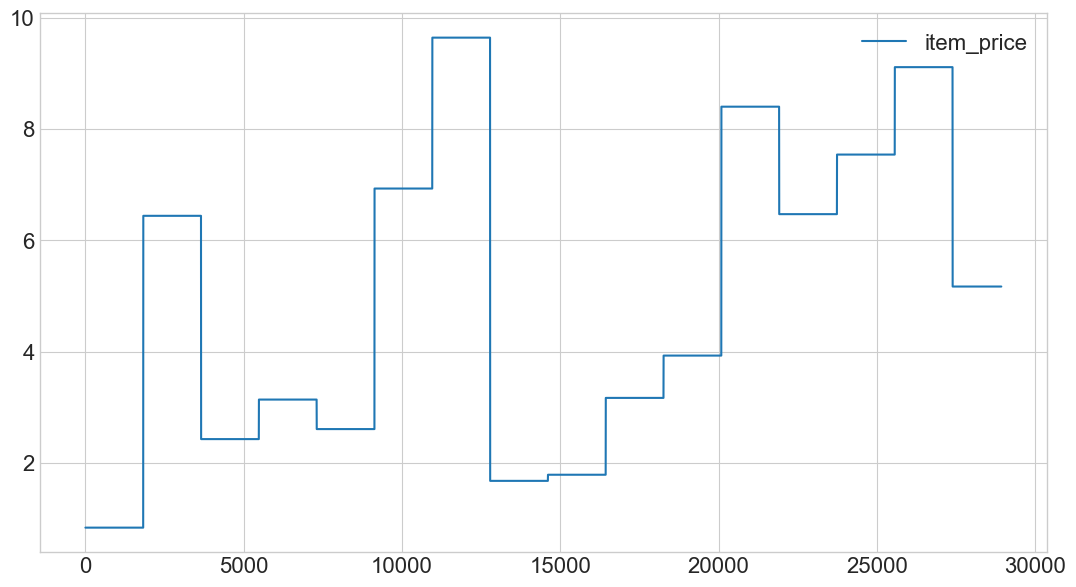

In [8]:
df[['item_price']].plot()

3. Set the index to be the datetime variable.

In [9]:
df = df.set_index('sale_date').sort_index()
df

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1.0,13.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2013-01-01,1,8,51600080015,51600080015,Lea & Perrins,Lea & Perrins Marinade In-a-bag Cracked Pepper...,1.68,127821.0,33.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2013-01-01,1,10,688267141676,688267141676,Ahold,Ahold Cocoa Almonds,3.17,164341.0,37.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2013-01-01,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,91301.0,31.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2013-01-01,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,54781.0,10.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,1,14,41167300121,41167300121,Pamprin,Pamprin Maximum Strength Multi-symptom Menstru...,7.54,239206.0,52.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2017-12-31,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,93126.0,53.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX
2017-12-31,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,56606.0,15.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX


4. Add a 'month' and 'day of week' column to your dataframe.

In [10]:
df['month']= df.index.month_name()
df['day_of_week'] = df.index.day_name()

In [11]:
df

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day_of_week
sale_date,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1.0,13.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday
2013-01-01,1,8,51600080015,51600080015,Lea & Perrins,Lea & Perrins Marinade In-a-bag Cracked Pepper...,1.68,127821.0,33.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday
2013-01-01,1,10,688267141676,688267141676,Ahold,Ahold Cocoa Almonds,3.17,164341.0,37.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday
2013-01-01,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,91301.0,31.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday
2013-01-01,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,54781.0,10.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,1,14,41167300121,41167300121,Pamprin,Pamprin Maximum Strength Multi-symptom Menstru...,7.54,239206.0,52.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday
2017-12-31,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,93126.0,53.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday
2017-12-31,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,56606.0,15.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday


5. Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.

In [14]:
df['sales_total']= df['sale_amount'] * df['item_price']

In [15]:
df

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1.0,13.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday,10.92
2013-01-01,1,8,51600080015,51600080015,Lea & Perrins,Lea & Perrins Marinade In-a-bag Cracked Pepper...,1.68,127821.0,33.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday,55.44
2013-01-01,1,10,688267141676,688267141676,Ahold,Ahold Cocoa Almonds,3.17,164341.0,37.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday,117.29
2013-01-01,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,91301.0,31.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday,214.83
2013-01-01,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,54781.0,10.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,January,Tuesday,31.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,1,14,41167300121,41167300121,Pamprin,Pamprin Maximum Strength Multi-symptom Menstru...,7.54,239206.0,52.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday,392.08
2017-12-31,1,6,74170388732,74170388732,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,93126.0,53.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday,367.29
2017-12-31,1,4,208528800007,208528800007,Boars Head,Boars Head Sliced White American Cheese - 120 Ct,3.14,56606.0,15.0,12125 Alamo Ranch Pkwy,78253.0,San Antonio,TX,December,Sunday,47.10


6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

# Prepare

In [16]:
def prepare_store_data(df):
    df['sale_date'] = pd.to_datetime(df.sale_date)
    df = df.set_index('sale_date').sort_index()
    df['month']= df.index.month_name()
    df['day_of_week'] = df.index.day_name()
    df['sales_total']= df['sale_amount'] * df['item_price']
    return df



# Exercise 2

Using the OPS data acquired in the Acquire exercises opsd_germany_daily.csv, complete the following:

1. Convert date column to datetime format.
2. Plot the distribution of each of your variables.
3. Set the index to be the datetime variable.
4. Add a month and a year column to your dataframe.
5. Fill any missing values.
6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')

In [18]:
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


1. Convert date column to datetime format.

In [19]:
df['Date'] = pd.to_datetime(df.Date)

2. Plot the distribution of each of your variables.


(array([ 162.,  492.,  665., 2568.,  207.,  120.,   72.,   58.,   29.,
          10.]),
 array([ 21.478 , 104.4858, 187.4936, 270.5014, 353.5092, 436.517 ,
        519.5248, 602.5326, 685.5404, 768.5482, 851.556 ]),
 <BarContainer object of 10 artists>)

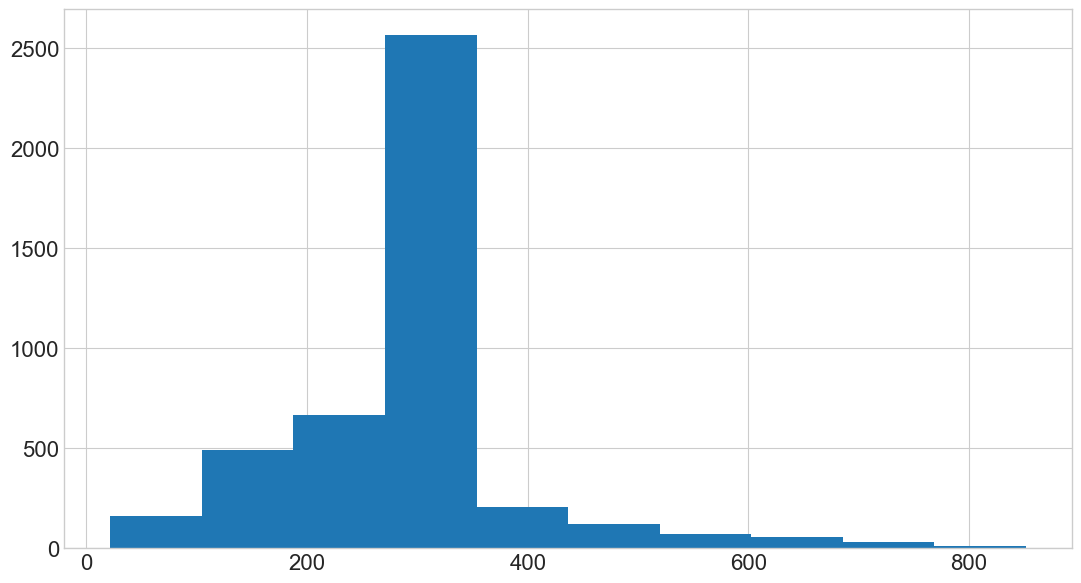

In [71]:
plt.hist(df['Wind+Solar'])

(array([ 414.,  341.,  228., 2425.,  272.,  271.,  198.,  149.,   67.,
          18.]),
 array([  1.968 ,  25.9292,  49.8904,  73.8516,  97.8128, 121.774 ,
        145.7352, 169.6964, 193.6576, 217.6188, 241.58  ]),
 <BarContainer object of 10 artists>)

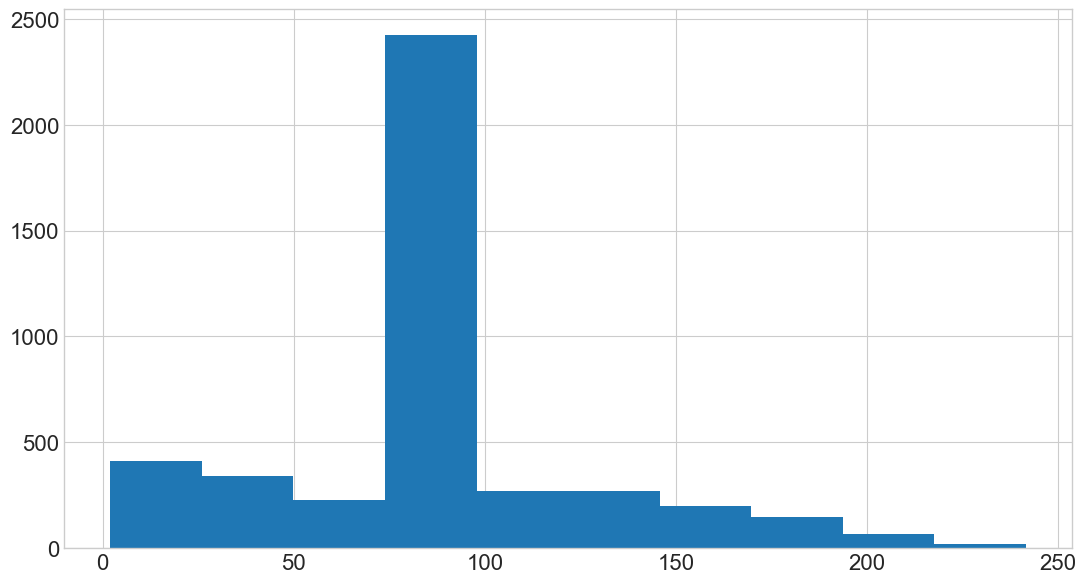

In [68]:
plt.hist(df.Solar)

(array([1105., 2237.,  444.,  254.,  141.,   74.,   49.,   48.,   25.,
           6.]),
 array([  5.757 ,  87.8091, 169.8612, 251.9133, 333.9654, 416.0175,
        498.0696, 580.1217, 662.1738, 744.2259, 826.278 ]),
 <BarContainer object of 10 artists>)

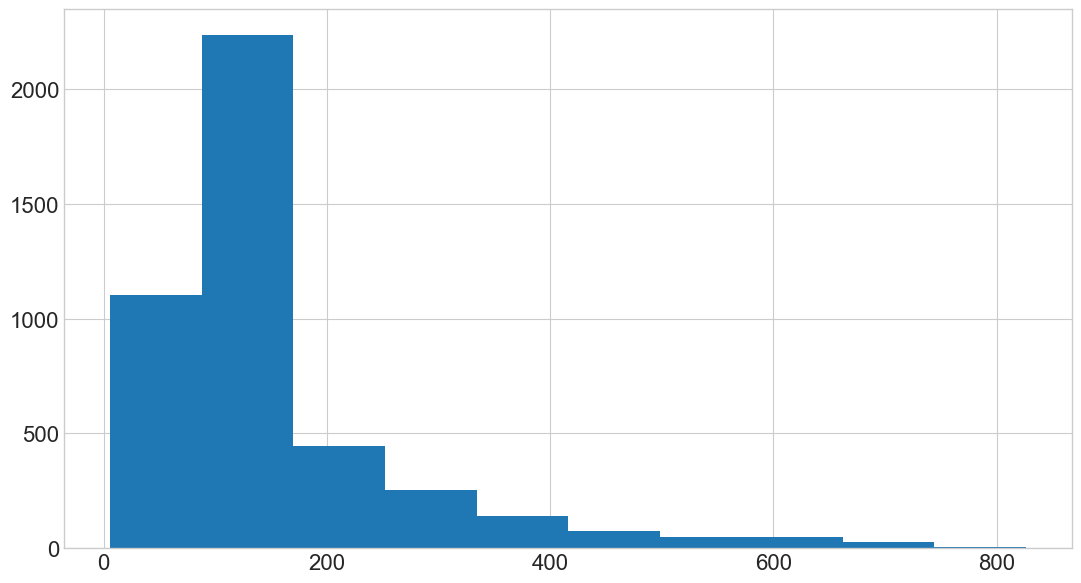

In [69]:
plt.hist(df.Wind)

(array([  15.,  123.,  360.,  457.,  443.,  740., 1057.,  700.,  426.,
          62.]),
 array([ 842.395 ,  929.1123, 1015.8296, 1102.5469, 1189.2642, 1275.9815,
        1362.6988, 1449.4161, 1536.1334, 1622.8507, 1709.568 ]),
 <BarContainer object of 10 artists>)

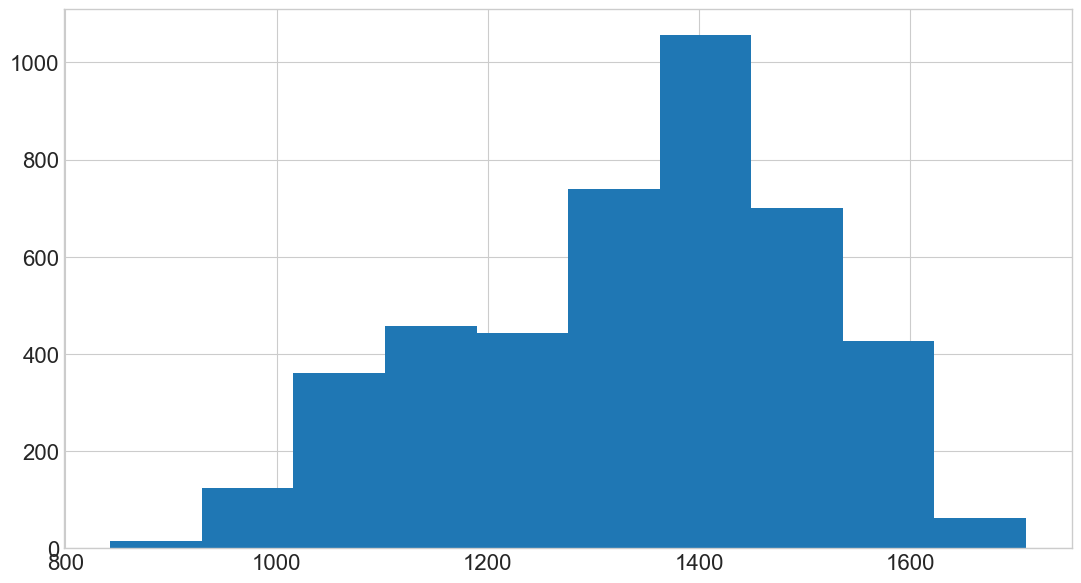

In [70]:
plt.hist(df.Consumption)

3. Set the index to be the datetime variable.


In [42]:
df = df.set_index('Date').sort_index()
df


,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


4. Add a month and a year column to your dataframe.


In [45]:
df['month']=df.index.month_name()
df['year']=df.index.year

In [46]:
df

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18400,NaN,NaN,NaN,January,2006
2006-01-02,1380.52100,NaN,NaN,NaN,January,2006
2006-01-03,1442.53300,NaN,NaN,NaN,January,2006
2006-01-04,1457.21700,NaN,NaN,NaN,January,2006
2006-01-05,1477.13100,NaN,NaN,NaN,January,2006
...,...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037,December,2017
2017-12-28,1299.86398,506.424,14.162,520.586,December,2017
2017-12-29,1295.08753,584.277,29.854,614.131,December,2017


5. Fill any missing values.


In [53]:
df=df.fillna(df.mean())

In [56]:
df.isna().sum()

Consumption    0
Wind           0
Solar          0
Wind+Solar     0
month          0
year           0
dtype: int64

In [ ]:
def prep_solar(df):
    df = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')
    df['Date'] = pd.to_datetime(df.Date)
    df = df.set_index('Date').sort_index()
    df['month']=df.index.month_name()
    df['year']=df.index.year
    df=df.fillna(df.mean())
    return df
    
    
    